In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
#tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler



import pickle

In [2]:

#http://10.79.85.55:8887/edit/data/MGP/TestPointsN2_CH4_H2O_000.xlsx
file_name = '/data/MGP/TestPointsN2_CH4_H2O_000.xlsx'
df=pd.read_excel(file_name,header=1).dropna(how='all', axis=1)
df.drop('#',axis=1,inplace=True)


In [3]:
phi_surge = 0.076 
df['surge_distance_from_eq'] = 100*(df['phi']-phi_surge)/phi_surge 

In [4]:
# func1 required columns
columns=['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power','phi',
         'Surge Distance','surge_distance_from_eq','GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
inputs = ['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power']
#outputs = ['GVFin','GVFout','Qin [m3/s]','Qv_out [m3/s]','phi','Surge Distance','surge_distance_from_eq']
#outputs = ['GVFin','GVFout','Qin [m3/s]','Qv_out [m3/s]']
outputs = ['surge_distance_from_eq']
data=df[columns]
X=data[inputs]
y=data[outputs]

In [5]:
# MAE is 0.57  for batch size 32 and epochs 250 
# columns=['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power','GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
# inputs = ['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power']
# outputs = ['GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
# outputs_x = ['GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]'],

In [6]:
#func2 split ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)


In [7]:
# func3
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled
# scale the dataset
X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

## Train the model  

In [8]:
#import keras


from tensorflow import keras 
from keras import optimizers

checkpoint = keras.callbacks.ModelCheckpoint("mcp_x.h5", save_best_only=True)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer="l2", input_shape=[X_train.shape[1]]),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer="l2"),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    
  
    keras.layers.Dense(1)
])

model.compile(loss='mae',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-2, decay=0.1),
              metrics=['mae'])
              
history = model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=1024, #64,
    validation_split=0.2,
    callbacks=[checkpoint]
)

2022-04-12 12:59:27.847416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 237 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2022-04-12 12:59:28.004575: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
40/40 [==============================] - 3s 14ms/step - loss: 26.6596 - mae: 26.5063 - val_loss: 26.0326 - val_mae: 25.9346
Epoch 2/500
40/40 [==============================] - 0s 13ms/step - loss: 22.3718 - mae: 22.2947 - val_loss: 24.0982 - val_mae: 24.0380
Epoch 3/500
40/40 [==============================] - 0s 6ms/step - loss: 20.0462 - mae: 19.9927 - val_loss: 22.6573 - val_mae: 22.6093
Epoch 4/500
40/40 [==============================] - 0s 9ms/step - loss: 18.3356 - mae: 18.2909 - val_loss: 21.4827 - val_mae: 21.4407
Epoch 5/500
40/40 [==============================] - 0s 10ms/step - loss: 16.9626 - mae: 16.9225 - val_loss: 20.8372 - val_mae: 20.7987
Epoch 6/500
40/40 [==============================] - 0s 6ms/step - loss: 15.8091 - mae: 15.7716 - val_loss: 19.8595 - val_mae: 19.8229
Epoch 7/500
40/40 [==============================] - 0s 10ms/step - loss: 14.8096 - mae: 14.7736 - val_loss: 19.0793 - val_mae: 19.0440
Epoch 8/500
40/40 [==============================] 

In [9]:
# for 4 outputs
# decreasing batch size to 32 and increasing epochs to 400 give more error takes more time to reach the same mae of
# 213 0.73
# compared to batch size 64 at epoch 53 val_mae is 0.65, minimum is 0.58

# for extended outputs same config above
# mae is 

## load the saved model and predict for unseen data

In [10]:
test_data = y_test[outputs]
# the saved model is loaded to make predictions on the new data(X_test)
model_loaded = tf.keras.models.load_model('mcp_x.h5')

# predictions from the saved model
pred_test_loaded = model_loaded.predict(X_test_scaled)

print("RMSE Test_x",np.sqrt(mean_squared_error(test_data,pred_test_loaded))) # optional get the error from the predictions
print("R2 score Test_x",r2_score(test_data,pred_test_loaded))

RMSE Test_x 2.687273092295122
R2 score Test_x 0.9856309952916443


In [11]:
y_test[0:4]

,surge_distance_from_eq
6188,20.677098
40868,42.117870
36553,53.090574
57857,32.876043


In [33]:
# data_test = data.iloc[X_test.index.values,:]

In [34]:
# data_test['surge_distance_from_eq_pred']=pred_test_loaded

In [35]:
pred_test_loaded[0:4]

array([[ 8.953308],
       [35.86303 ],
       [51.007423],
       [18.447609]], dtype=float32)

In [36]:
for i, out in enumerate(outputs):
    test_data[out+'_pred'] = pred_test_loaded[:,i]
for i, out in enumerate(outputs):
    test_data[out+'_residuals'] = test_data[out] - test_data[out+'_pred']

In [37]:
test_data.head(4)

,surge_distance_from_eq,surge_distance_from_eq_pred,surge_distance_from_eq_residuals,N [rpm]
6188,20.677098,8.953308,11.723790,2129.434401
40868,42.117870,35.863029,6.254840,4961.807221
36553,53.090574,51.007423,2.083151,4020.370134
57857,32.876043,18.447609,14.428434,2215.594019


In [38]:
test_data.columns

Index(['surge_distance_from_eq', 'surge_distance_from_eq_pred',
       'surge_distance_from_eq_residuals', 'N [rpm]'],
      dtype='object')

In [39]:
import math
df_metrics=pd.DataFrame(columns=['Variable','RMSE','R²'])
A=[];B=[];C=[]
for i, out in enumerate(outputs):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(test_data[out],test_data[out+'_pred'])),4))
    C.append(round(r2_score(test_data[out],test_data[out+'_pred']),4))
# phi, surge distance, Surge_distance_eq are from the predictions
df_metrics['Variable']=A
df_metrics['RMSE']=B
df_metrics['R²']=C

In [18]:
df_metrics

,Variable,RMSE,R²
0,surge_distance_from_eq,2.6873,0.9856


In [41]:
data_test = test_data.copy()

In [42]:
out='surge_distance_from_eq'
data_test['ErrSDpc']=abs(data_test[out]-data_test[out+'_pred'])/data_test[out]*100

(-10.0, 100.0)

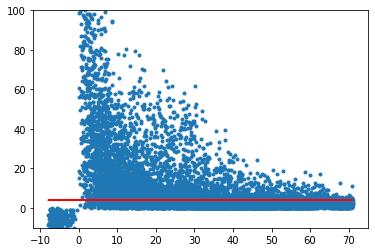

In [45]:
plt.plot(data_test[out],data_test['ErrSDpc'],'.')
plt.plot(data_test[out],4*np.ones(len(data_test[out])),'r')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
plt.ylim(-10,100)

In [46]:
ds=data_test['ErrSDpc'][data_test['ErrSDpc']<4]
fracOK=len(ds)/len(data_test)
fracOK

0.6238910012674271

In [50]:
# Get mean as standard deviation
mean = data_test[out+'_residuals'].mean()
std = data_test[out+'_residuals'].std()
std

2.652758952842668

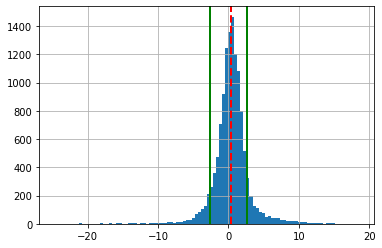

In [51]:
data_test[out+'_residuals'].hist(bins=100)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(std, color='g', linewidth=2)
plt.axvline(-std, color='g', linewidth=2)

<AxesSubplot:>

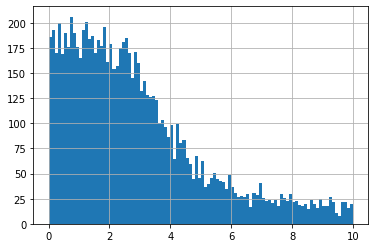

In [52]:
data_test['ErrSDpc'].hist(bins=100,range=[0,10])